In [1]:
import os
%load_ext autoreload
%autoreload 2

In [2]:
cd ~/workspace/theislab/mubind/docs/notebooks/batch

/mnt/c/Users/ignacio.ibarra/Dropbox/workspace/theislab/mubind/docs/notebooks/batch


In [51]:
import mubind as mb
import numpy as np
import pandas as pd
import torch
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = '../../../annotations' # '../../annotations'
# mb.models.MultiBind
import torch.optim as topti
import torch.utils.data as tdata
import numpy as np

# Use a GPU if available, as it should be faster.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

Using device: cuda:0


In [84]:
df = mb.bindome.datasets.ProBound.ctcf(flank_length=0)
df = df.sort_values(1, ascending=False).reset_index(drop=True)
# data = df.head(1000)
# data = df.copy()

df.index = df['seq']
del df['seq']
df.index = df.index.astype(str).str[45:]

df = df[~df.index.duplicated(keep='first')]

n_sample = 5000
if n_sample is not None:
    data = df.sample(min(df.shape[0], n_sample))
else:
    data = df.copy()

# data = mb.pp.sample_rounds(df, 2, 10000)

# remove as many nucleotides as posisble (faster training/convergence)


# data.index = data.index.astype(str).str[-15:]


In [85]:
df.shape

(120053, 2)

In [86]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 5, 1

In [87]:
# TODO: skipped for now
n_rounds = 2

print('loading object (# entries)', data.shape[0])
dataset = mb.datasets.SelexDataset(data, n_rounds=n_rounds, labels=[0, 1])
train = tdata.DataLoader(dataset=dataset,
                         # batch_size=256,
                         batch_size=625,
                         shuffle=False)

loading object (# entries) 5000


In [88]:
import warnings
warnings.filterwarnings('ignore')

In [89]:
# %lprun -f mb.tl.train_network mb.tl.train_network(model, train, device, next_optimiser, criterion, num_epochs=20, early_stopping=100, log_each=2, dirichlet_regularization=0, exp_max=40, verbose=0)

In [90]:
# %lprun -f mb.tl.train_iterative mb.tl.train_iterative(train, device, w=18, show_logo=False, opt_kernel_shift=0, opt_kernel_length=0, dirichlet_regularization=dirichlet_regularization, lr=[0.01, 0.01], weight_decay=[0.01, 0.001], ignore_kernel=ignore_kernel, num_epochs=2, early_stopping=100, use_dinuc=False, n_kernels=n_kernels, log_each=log_each, stop_at_kernel=None)

In [91]:
pd.set_option('display.expand_frame_repr', False)


In [92]:
# assign batch and data type

# data['batch'] = 0
# data['is_count_data'] = 1
# n_batches=3

dirichlet_regularization = 0
# for dirichlet_regularization_log in range(-5, 3):

n_epochs = 100
log_each = 10
n_kernels = 2
lr = [0.01] * n_kernels
kernels = [0, 2] + [20] * (n_kernels - 1)
wd = [0.01,] + [0.001] * (n_kernels - 1)
early_stopping = [5,] + [10] * (n_kernels)

opt_kernel_shift = [0, 0] + [1] * (n_kernels - 1)
opt_kernel_length = [0, 0] + [1] * (n_kernels - 1)
use_mono = True
use_dinuc = True
dinuc_mode = 'local'

from matplotlib import rcParams
rcParams['figure.figsize'] = 8, 1

import time
t0 = time.time()

criterion = mb.tl.PoissonLoss()



False False False
current kernels

Kernel to optimize 0

FREEZING KERNELS
optimizing feature type mono
setting grad status of kernel (mono, dinuc) at 0 to (1, 0)
activities status False
setting grad status of kernel (mono, dinuc) at 1 to (0, 0)
activities status False
setting grad status of kernel (mono, dinuc) at 2 to (0, 0)
activities status False
kernels mask None
optimizer:  Adam 
criterion: PoissonLoss 
# epochs: 100 
early_stopping: 5
lr= 0.01, weight_decay= 0.001, dir weight= 0
Epoch: 11, Loss: 1.894747, R2: -1.13,  best epoch: 9,  secs per epoch: 0.211 s,  secs epoch*1k trials: 0.042s
Epoch: 21, Loss: 1.436684, R2: -0.97,  best epoch: 19,  secs per epoch: 0.228 s,  secs epoch*1k trials: 0.046s
Epoch: 31, Loss: 1.072951, R2: -0.52,  best epoch: 29,  secs per epoch: 0.196 s,  secs epoch*1k trials: 0.039s
Epoch: 41, Loss: 0.895124, R2: -0.09,  best epoch: 39,  secs per epoch: 0.178 s,  secs epoch*1k trials: 0.036s
Epoch: 51, Loss: 0.850286, R2: 0.03,  best epoch: 49,  secs per epo

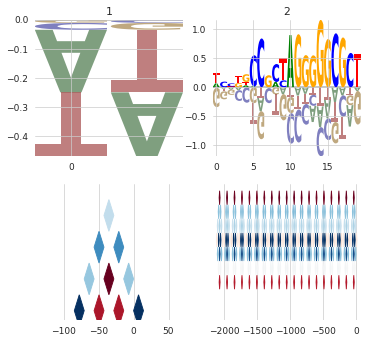

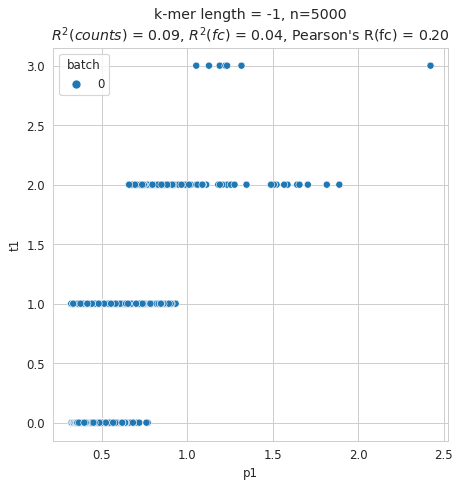

In [93]:
import itertools

models = []
for optimize_exp_barrier, optimize_kernel_rel, optimize_sym_weight in [[False, False, False]]: # list(itertools.product([True, False], repeat=3)):
    print(optimize_exp_barrier, optimize_kernel_rel, optimize_sym_weight)
    model = mb.models.Multibind.make_model(train, n_kernels, criterion, kernels=kernels,
                                           use_dinuc=use_dinuc, dinuc_mode=dinuc_mode,
                                           optimize_exp_barrier= optimize_exp_barrier,
                                           optimize_kernel_rel = optimize_kernel_rel,
                                           device=device,
                                           optimize_sym_weight = optimize_sym_weight) # .cuda()

    model, best_loss = model.optimize_iterative(train,
                                                show_logo=0,
                                                r2_per_epoch=True,
                                                opt_kernel_length=opt_kernel_length,
                                                opt_kernel_shift=opt_kernel_shift,
                                                dirichlet_regularization=dirichlet_regularization, # 10 ** dirichlet_regularization_log,
                                                # lr=lr, weight_decay=wd, ignore_kernel=ignore_kernel,
                                                # skip_kernels={2, 3},
                                                n_epochs=n_epochs,
                                                early_stopping=early_stopping, # optimiser=torch.optim.LBFGS,
                                                log_each=log_each,
                                                stop_at_kernel=None) #  seed=seed) # seeds.index[0]) #
    print('##DONE....\n\n')
    # print('total time: %.3f s' % ((time.time() - t0)))
    # # res = []
    # # model_by_k = {}
    #
    # counts = mb.tl.predict(model, train)
    # print(counts)
    #
    mb.pl.set_rcParams({'figure.figsize': [10, 6], 'figure.dpi': 65})
    mb.pl.conv(model)
    #
    # mb.tl.scores(model, train, by='batch')
    mb.pl.set_rcParams({'figure.figsize': [6, 6], 'figure.dpi': 85})
    mb.pl.kmer_enrichment(model, train, log_scale=False, style='scatter', ylab='t1', xlab='p1')
    # mb.pl.activities(model)
    #
    # mb.pl.set_rcParams({'figure.figsize': [8, 4], 'figure.dpi': 85})
    # mb.pl.loss(model)

    models.append([model, best_loss])
    break

    # break


Text(0, 0.5, 'similar weights loss')

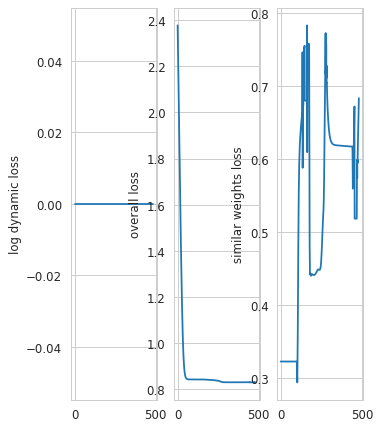

In [94]:
plt.subplot(1, 4, 1)
plt.plot(model.loss_history_log_dynamic)
plt.ylabel('log dynamic loss')
plt.subplot(1, 4, 2)
plt.plot(model.loss_history)
plt.ylabel('overall loss')
plt.subplot(1, 4, 3)
plt.plot(model.loss_history_sym_weights)
plt.ylabel('similar weights loss')


In [95]:
for m, best_loss in models:
    print(m.optimize_exp_barrier, m.optimize_kernel_rel, m.optimize_sym_weight, m.r2_final, m.total_time)


False False False 0.08454303092444437 65.0675938129425


True
3
0 out of 3...


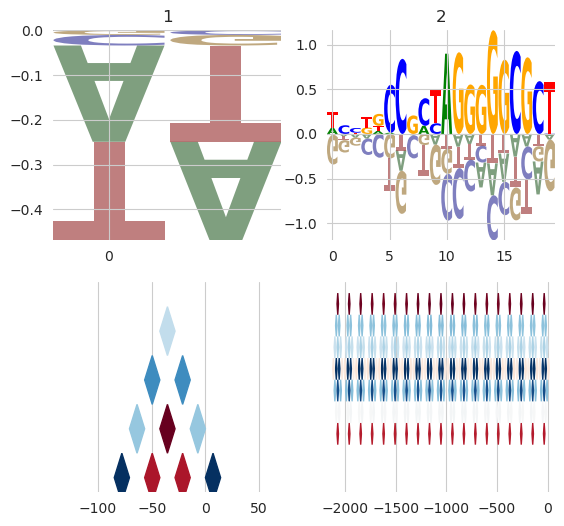

In [96]:
mb.pl.set_rcParams({'figure.figsize': [10, 6], 'figure.dpi': 100})
for m, best_loss in models:
    #print(m.optimize_exp_barrier, m.optimize_kernel_rel, m.optimize_sym_weight, m.r2_final, m.total_time)
    mb.pl.conv(m)


In [97]:
model

Multibind(
  (padding): ConstantPad2d(padding=(19, 19, 0, 0), value=0.25)
  (binding_modes): BindingModesSimple(
    (conv_mono): ModuleList(
      (0): None
      (1): Conv2d(1, 1, kernel_size=(4, 2), stride=(1, 1), bias=False)
      (2): Conv2d(1, 1, kernel_size=(4, 20), stride=(1, 1), bias=False)
    )
    (conv_di): ModuleList(
      (0): None
      (1): Conv2d(1, 1, kernel_size=(16, 1), stride=(1, 1), bias=False)
      (2): Conv2d(1, 1, kernel_size=(16, 19), stride=(1, 1), bias=False)
    )
  )
  (activities): ActivitiesLayer(
    (log_activities): ParameterList(
        (0): Parameter containing: [torch.cuda.FloatTensor of size 1x2 (GPU 0)]
        (1): Parameter containing: [torch.cuda.FloatTensor of size 1x2 (GPU 0)]
        (2): Parameter containing: [torch.cuda.FloatTensor of size 1x2 (GPU 0)]
    )
  )
  (selex_module): SelexModule()
  (criterion): PoissonLoss()
)

<AxesSubplot: xlabel='index', ylabel='r2'>

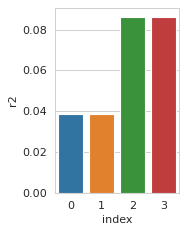

In [98]:
# contributions per newly added kernel
rcParams['figure.figsize'] = 2, 3
rcParams['figure.dpi'] = 80
import seaborn as sns
r2 = pd.DataFrame(model.best_r2_by_new_filter, columns=['r2']).reset_index()
sns.barplot(data=r2, x='index', y='r2')


Text(0.5, 0, '# epochs')

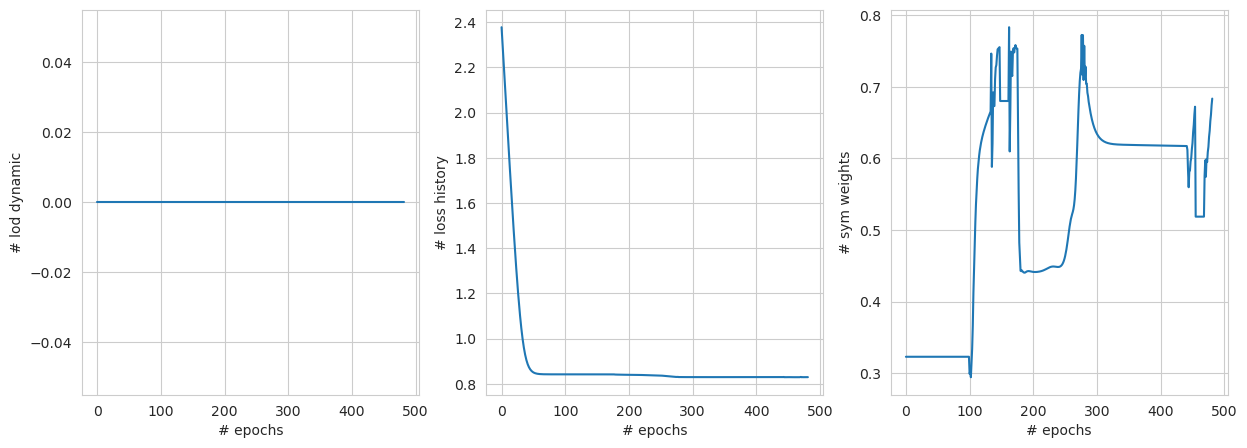

In [99]:
import matplotlib.pyplot as plt
rcParams['figure.figsize'] = 20, 5
rcParams['figure.dpi'] = 100

plt.subplot(1, 4, 1)
plt.plot(model.loss_history_log_dynamic)
plt.ylabel('# lod dynamic')
plt.xlabel('# epochs')
plt.subplot(1, 4, 2)
plt.plot(model.loss_history)
plt.ylabel('# loss history')
plt.xlabel('# epochs')
plt.subplot(1, 4, 3)
plt.plot(model.loss_history_sym_weights)
plt.ylabel('# sym weights')
plt.xlabel('# epochs')


In [1]:
mb.pl.activities(model)


NameError: name 'mb' is not defined